# Ames Housing Dataset - Regression 

In this notebook, we're going to analyze housing data to predict the sale price of a home based on other attributes in the dataset. This dataset contains information from homes in Ames, Iowa. To get a detailed explanation of each of the features in the dataset, please click [here](https://github.com/matthew-macwan/Advanced_Regression_Techniques/blob/main/data_description.txt).

Project Outline: 

 -  We will begin with some exploratory data analysis, seeing what trends or patterns we can find.
 -  Next, we will clean the data and output it into a new CSV file.
 -  Now, we will build various different models to see which one performed best.
 - Lastly, we will fine tune the best models and see if we can make them better.


In [1]:
#import some packages 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator 
import seaborn as sns

from scipy import stats 
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

import warnings
warnings.filterwarnings('ignore')

#load the data 

train_data = pd.read_csv("train.csv")

#view the data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
#let's split the dataset by their datatypes into categorical and numerical features

num_columns = train_data.select_dtypes(exclude = 'object')

cat_columns = train_data.select_dtypes(include = 'object')

#join SalePrice back into categorical data

SL = train_data["SalePrice"]
cat_columns = cat_columns.join(SL)

## Exploratory Data Analysis

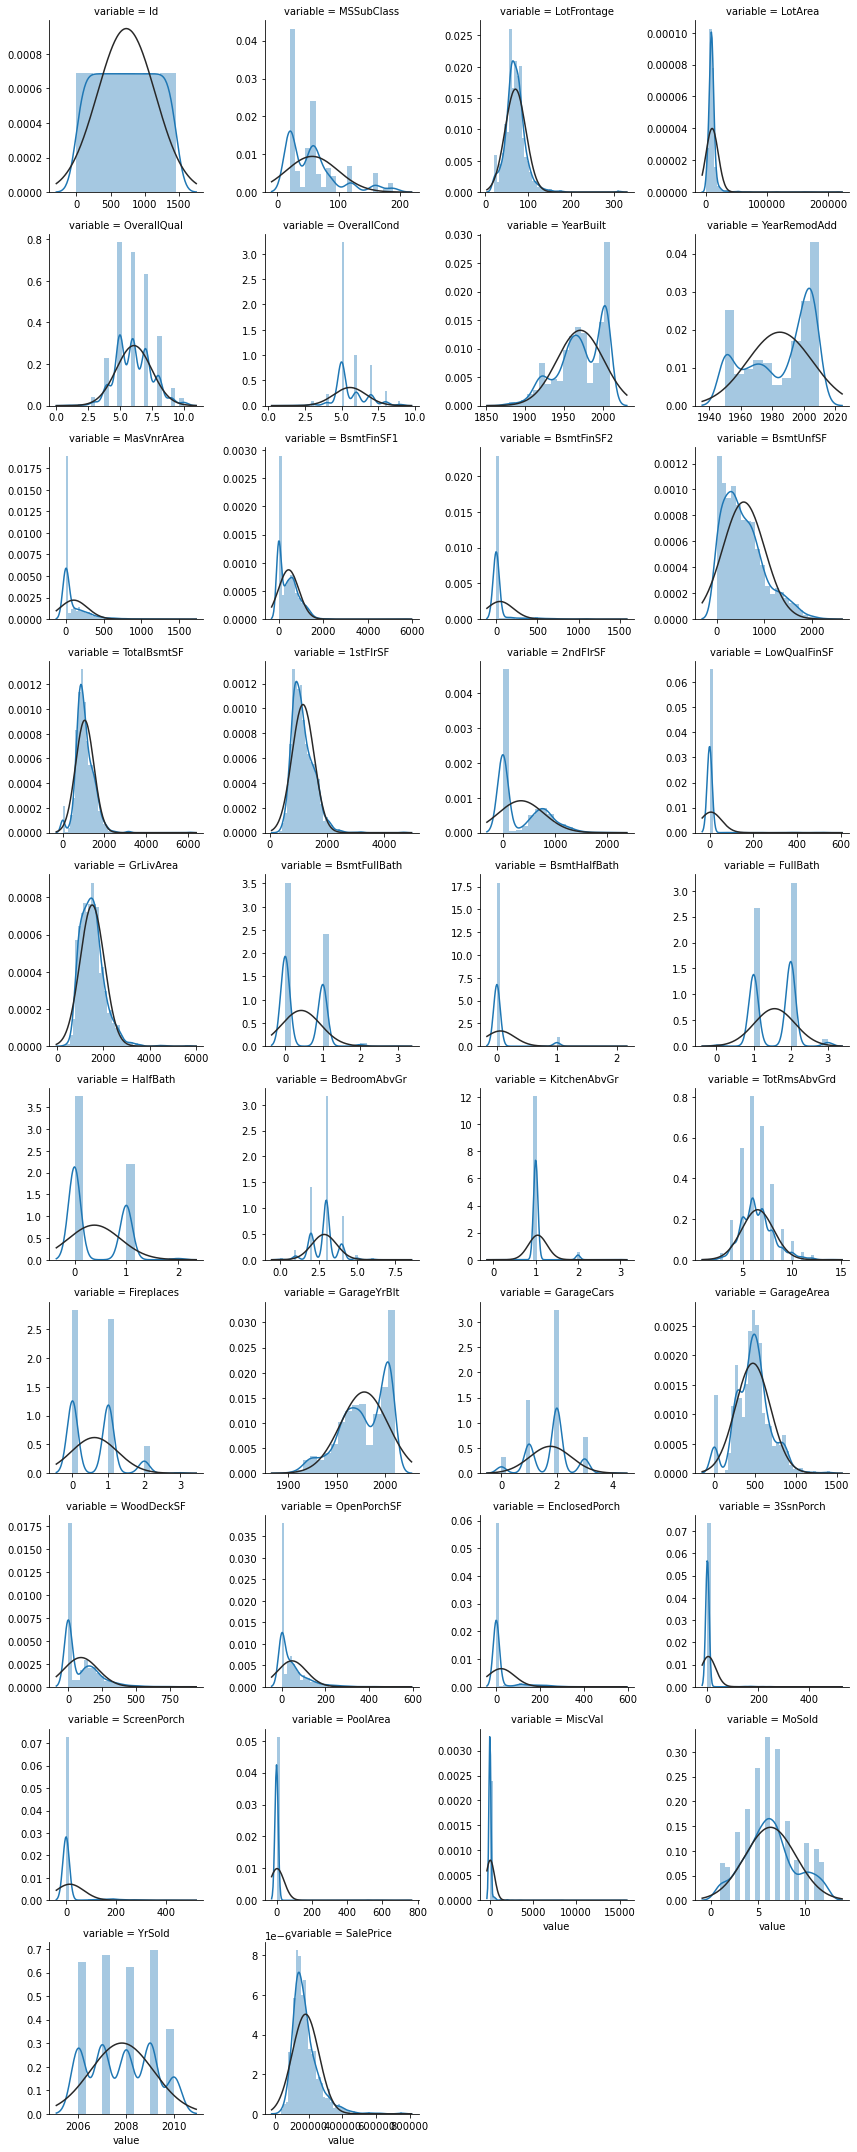

In [3]:
#let's write a function to view the skewness of the features 

def skew_graph(df):
    f = pd.melt(df, value_vars = df)
    g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
    g.map(lambda _x, **kwargs: sns.distplot(_x, fit = norm), 'value');
    
skew_graph(num_columns)

### Takeaways

Here, we can see that a good number of features in the dataset does not follow a normal distribution which can give us problems when we start building models. This is a problem that we will deal with later on using data transformations.

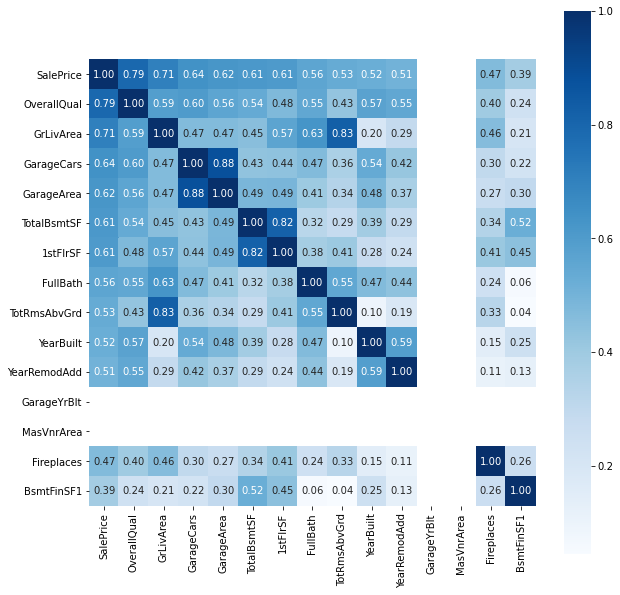

In [4]:
#let's write a function to view a correlation matrix

#correlation matrix with an input of a dataframe (df), the target variable (tv), number of attributes in matrix (k)

def corr_matrix(df, tv, k):
    corrmat = df.corr()
    cols = corrmat.nlargest(k, tv)[tv].index
    cm = np.corrcoef(df[cols].values.T)
    f, ax = plt.subplots(figsize=(10, 10))
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values, cmap = 'Blues')
    plt.show()
    
corr_matrix(num_columns, 'SalePrice', 15)

### Takeaways

From the correlation matrix, we can see that the OverallQual and GrLivArea are the top two most correlated
features. Following them is GarageCars and TotalBsmtSF.

It's important to take into account the colinearity between features as they can impact model performance.
We can see that GarageCars/GarageArea and TotalBsmtSF/1stFlrSF are highly correlated so we will have to deal with these problems by using attribute combinations or dropping the feature that is less correlated with SalePrice.

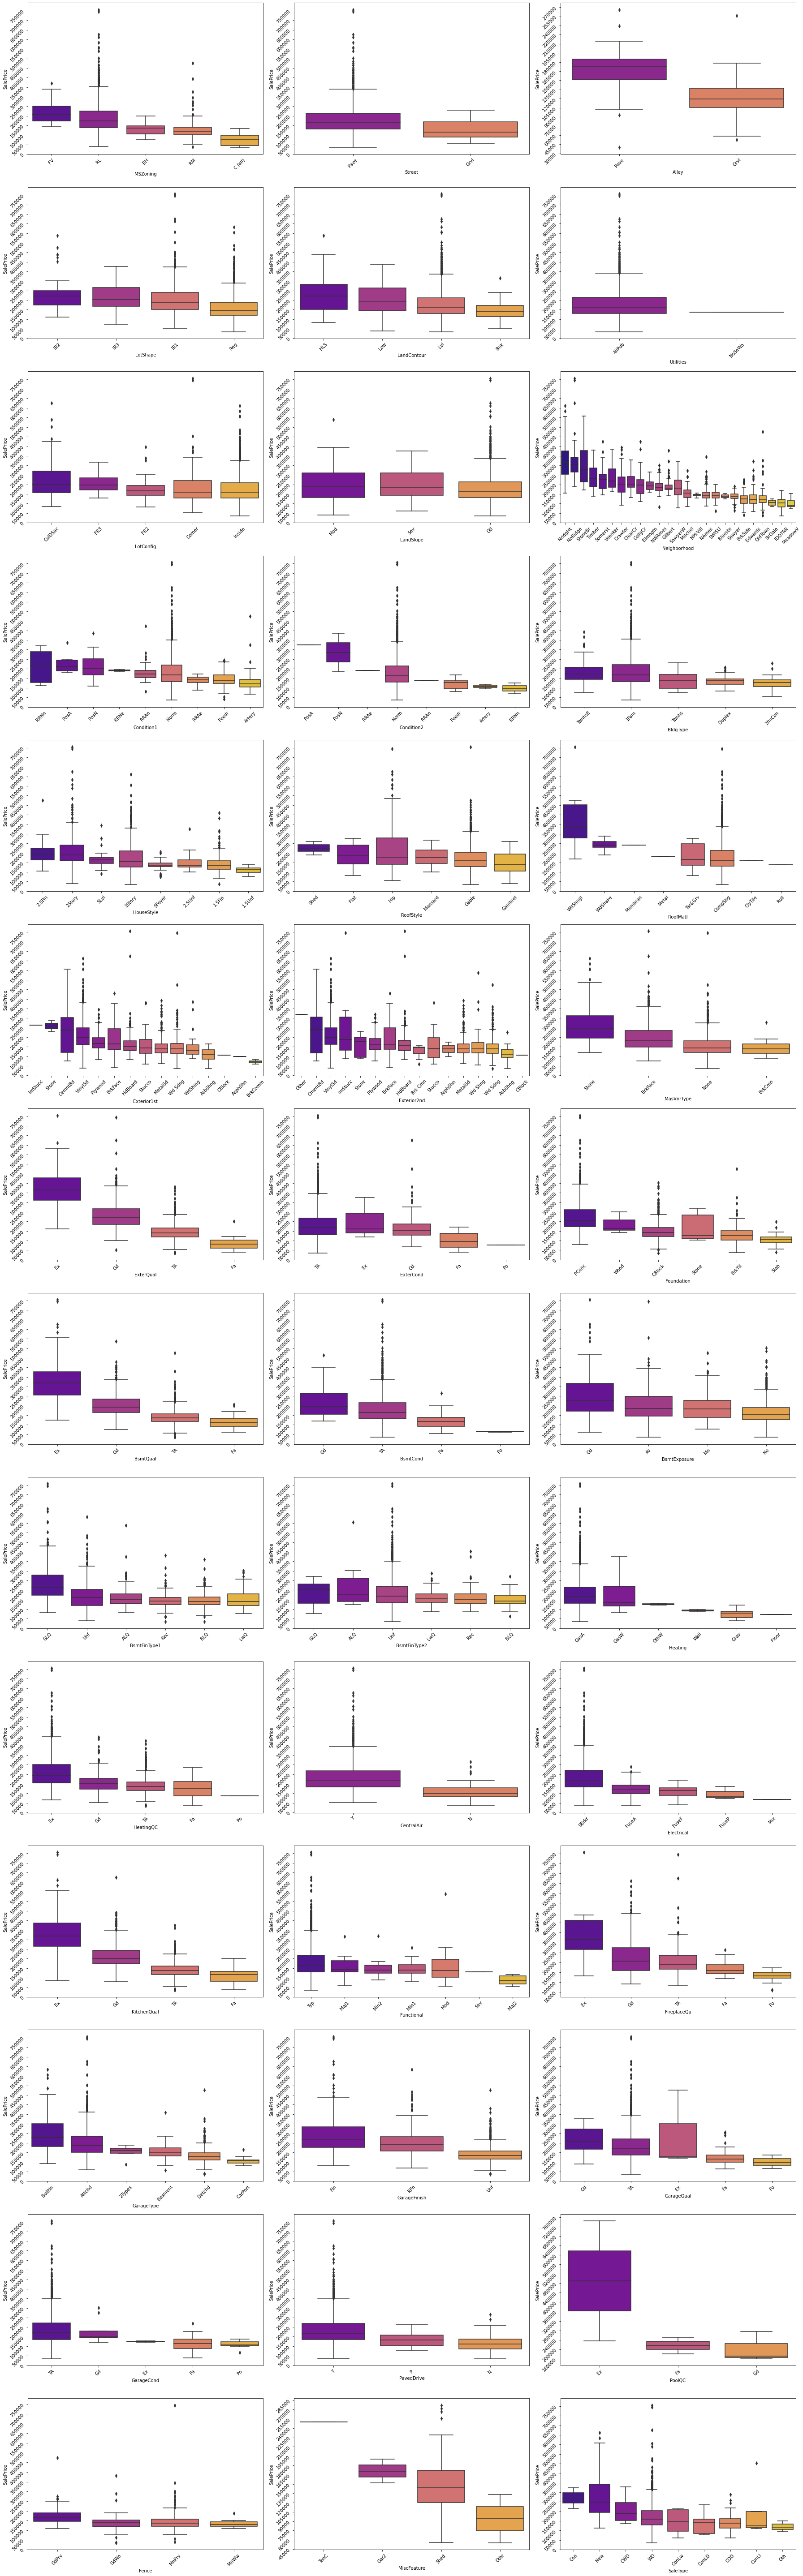

In [5]:
#write a function and visualize box plots for categorical data

def box_plot(df,y):
    fig, axes = plt.subplots(14, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df[[col for col in df]], axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()
        
box_plot(cat_columns, 'SalePrice')

### Takeaways

These box plots tell us alot about the data. 

- Homes with Central Air are generally more expensive than ones without central air.
- Basements seem to be an important feature. We can see a clear uptrend from low quality basements to higher quality ones in BsmtQual, BsmtCond, BsmtExposure.
- Homes with pools sell for much more than homes without pools.
- Fireplace quality seems to be important and this makes sense. Winters in the MidWest are very cold. 
- Kitchen quality drives up the prices of a home.
- Neighborhoods also impact sales price, we can see which neighborhoods have highest and lowest sales. It would be a good idea to encode neighborhoods with similar sale prices together to convert them into numerical features.

In [6]:
#let's create some new attributes to see if they correlate better with sale price. 

#create total square feet and total bathrooms attributes

num_columns['Total_Sq_Feet'] = (num_columns['BsmtFinSF1'] + num_columns['BsmtFinSF2'] + 
                       num_columns['1stFlrSF'] + num_columns['2ndFlrSF'])

num_columns['Total_Bathrooms'] = (num_columns['FullBath'] +
                              (0.5 * num_columns['HalfBath']) +
                              num_columns['BsmtFullBath'] +
                              (0.5 * num_columns['BsmtHalfBath']))

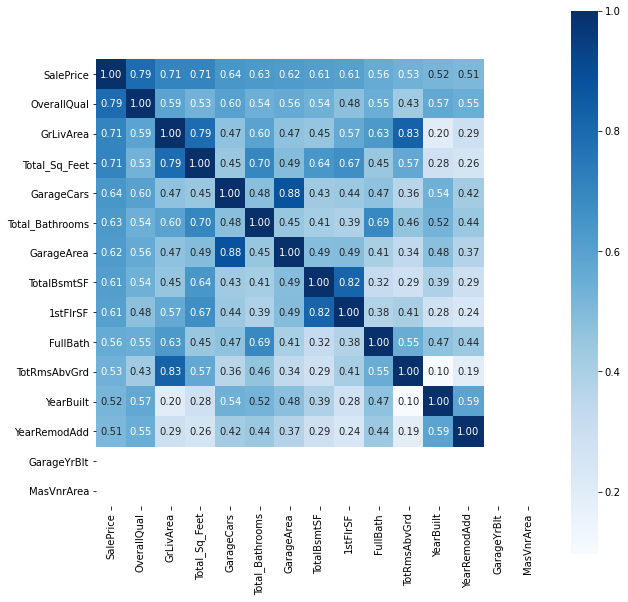

In [7]:
corr_matrix(num_columns,'SalePrice',15)

### Data Cleaning

Machine learning algorithms don't work with missing data so lets see how many null values we have and fix it.

In [8]:
#quick report on null values, takes in a dataframe

def null_report(df):
    new_df = pd.DataFrame(df.isnull().sum()).reset_index()
    new_df = new_df.rename(columns = {'index': 'Column Name', 0: 'Number of Null Values'}, inplace = False)
    new_df['Percentage of Null Values'] = (new_df['Number of Null Values']/len(df)*100) 
    print(new_df.sort_values(by = 'Percentage of Null Values', ascending = False).head(20))
    
null_report(train_data)

     Column Name  Number of Null Values  Percentage of Null Values
72        PoolQC                   1453                  99.520548
74   MiscFeature                   1406                  96.301370
6          Alley                   1369                  93.767123
73         Fence                   1179                  80.753425
57   FireplaceQu                    690                  47.260274
3    LotFrontage                    259                  17.739726
59   GarageYrBlt                     81                   5.547945
64    GarageCond                     81                   5.547945
58    GarageType                     81                   5.547945
60  GarageFinish                     81                   5.547945
63    GarageQual                     81                   5.547945
35  BsmtFinType2                     38                   2.602740
32  BsmtExposure                     38                   2.602740
30      BsmtQual                     37                   2.53

In [9]:
#null values in numerical features

null_report(num_columns)

      Column Name  Number of Null Values  Percentage of Null Values
2     LotFrontage                    259                  17.739726
25    GarageYrBlt                     81                   5.547945
8      MasVnrArea                      8                   0.547945
0              Id                      0                   0.000000
30  EnclosedPorch                      0                   0.000000
23   TotRmsAbvGrd                      0                   0.000000
24     Fireplaces                      0                   0.000000
26     GarageCars                      0                   0.000000
27     GarageArea                      0                   0.000000
28     WoodDeckSF                      0                   0.000000
29    OpenPorchSF                      0                   0.000000
32    ScreenPorch                      0                   0.000000
31      3SsnPorch                      0                   0.000000
21   BedroomAbvGr                      0        

In [10]:
#replace NaN in num_columns with median values 

num_columns=num_columns.fillna(num_columns.median())

In [11]:
#updated num_columns null report

null_report(num_columns)

      Column Name  Number of Null Values  Percentage of Null Values
0              Id                      0                        0.0
1      MSSubClass                      0                        0.0
22   KitchenAbvGr                      0                        0.0
23   TotRmsAbvGrd                      0                        0.0
24     Fireplaces                      0                        0.0
25    GarageYrBlt                      0                        0.0
26     GarageCars                      0                        0.0
27     GarageArea                      0                        0.0
28     WoodDeckSF                      0                        0.0
29    OpenPorchSF                      0                        0.0
30  EnclosedPorch                      0                        0.0
31      3SsnPorch                      0                        0.0
32    ScreenPorch                      0                        0.0
33       PoolArea                      0        

In [12]:
#null values in categorical features

null_report(cat_columns)

     Column Name  Number of Null Values  Percentage of Null Values
38        PoolQC                   1453                  99.520548
40   MiscFeature                   1406                  96.301370
2          Alley                   1369                  93.767123
39         Fence                   1179                  80.753425
32   FireplaceQu                    690                  47.260274
33    GarageType                     81                   5.547945
35    GarageQual                     81                   5.547945
34  GarageFinish                     81                   5.547945
36    GarageCond                     81                   5.547945
25  BsmtFinType2                     38                   2.602740
23  BsmtExposure                     38                   2.602740
24  BsmtFinType1                     37                   2.534247
21      BsmtQual                     37                   2.534247
22      BsmtCond                     37                   2.53

In [13]:
#replacing NaN with None in columns

col_names = list(cat_columns)

for col in col_names:
    cat_columns[col].fillna('None',inplace=True)

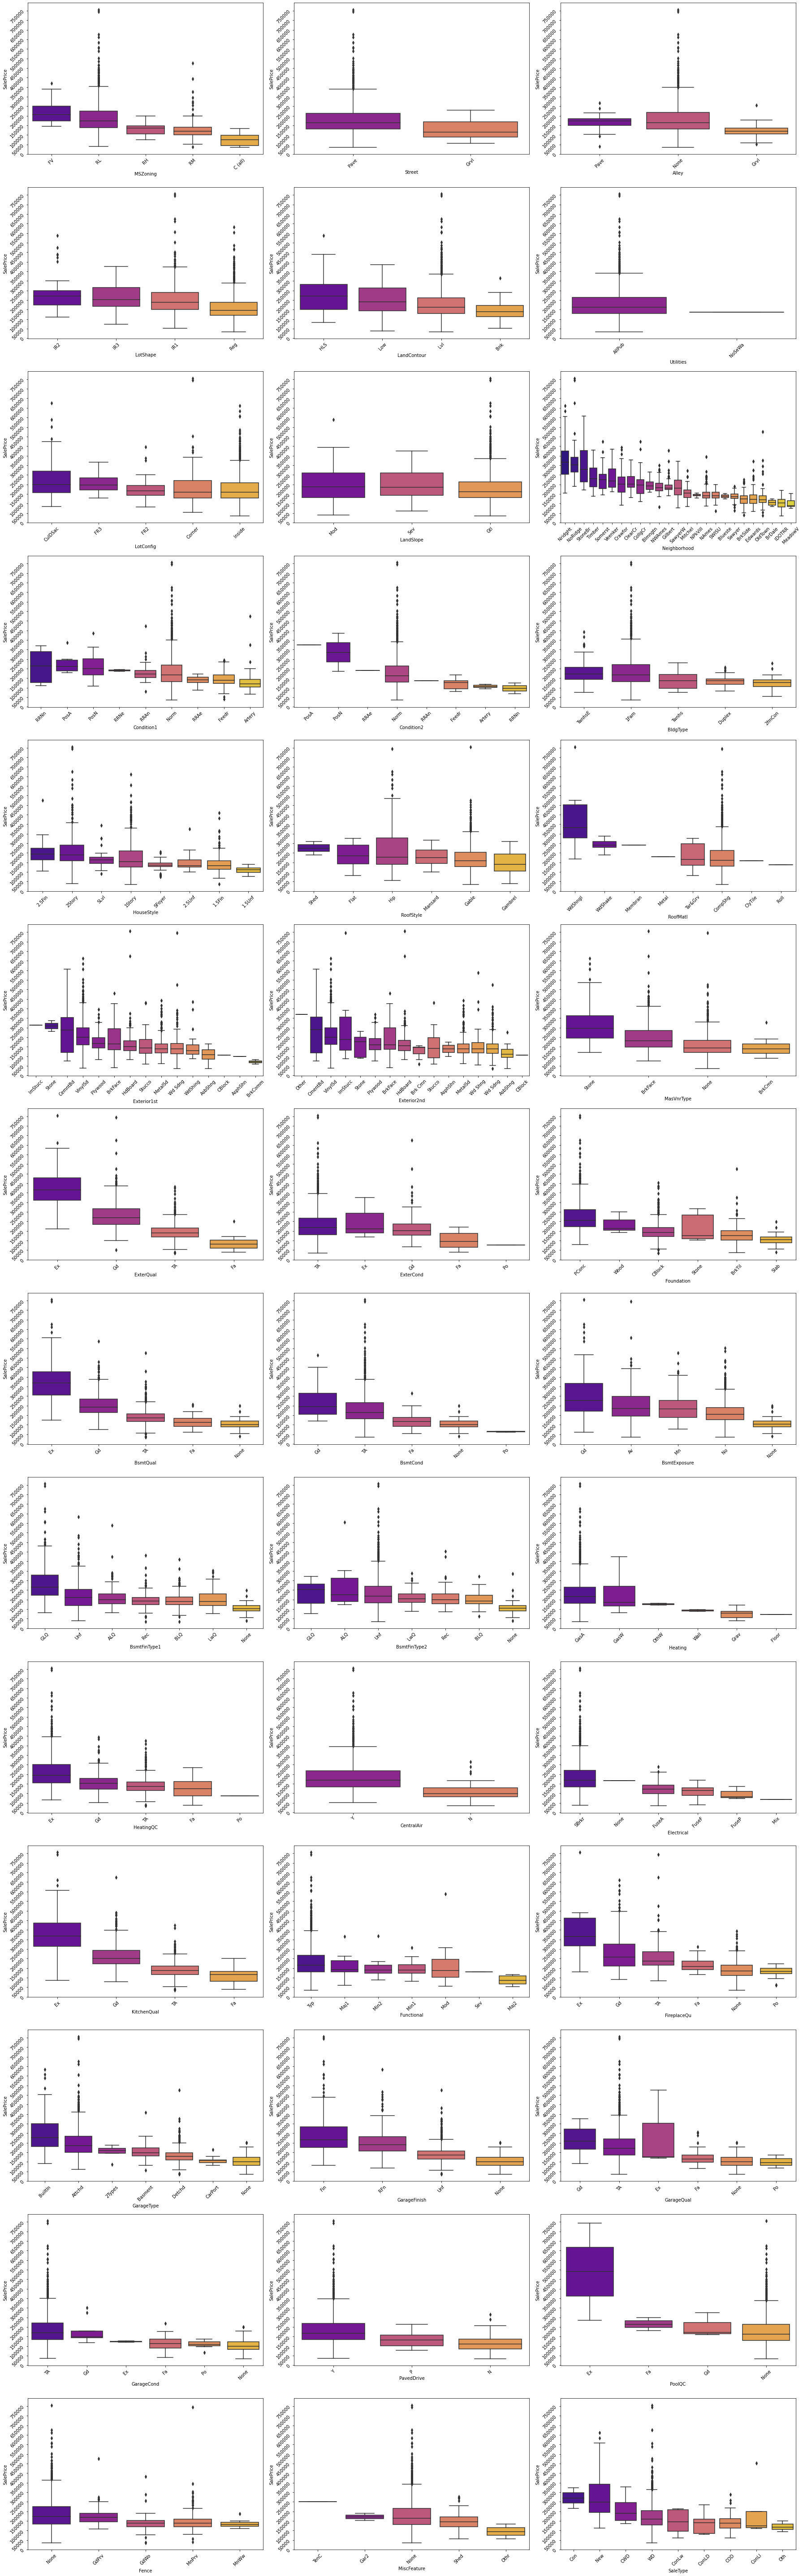

In [14]:
#create a new box plot analysis showing the changes with the NaN values filled in

box_plot(cat_columns, 'SalePrice')

### Takeaways

It is important to do EDA before and after you fill in null values because we want to look at the true data before we impute new values in. Furthermore, there may be some interesting findings after you input the null data and we can see examples of that in the new box plot.

- Homes with no fence do not seem to impact sale price drastically.
- BsmtCond with a None value are worth more than basment conditions of poor condition.
- Homes with a None value for Alley are worth more than homes with a gravel alley.

In [15]:
#let's encode and convert these categorical features into numerical features 

Street_map = {'Pave':2, 'Grvl':1}
cat_columns['Street'] = cat_columns['Street'].map(Street_map).astype('int')

Alley_map = {'Pave':2, 'Grvl':1, 'None':2}
cat_columns['Alley'] = cat_columns['Alley'].map(Alley_map).astype('int')

LContour_map = {'HLS':4, 'Low':3, 'Lvl':2, 'Bnk':1}
cat_columns['LandContour'] = cat_columns['LandContour'].map(LContour_map).astype('int')

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}
cat_columns['Neighborhood'] = cat_columns['Neighborhood'].map(neigh_map).astype('int')


HStyle_map = {'1Story':3, '1.5Fin':2, '1.5Unf':1, '2Story':4, '2.5Fin':4,'2.5Unf':2,'SFoyer':3, 'SLvl':3}
cat_columns['HouseStyle'] = cat_columns['HouseStyle'].map(HStyle_map).astype('int')

GT_map = {'2Types':5 , 'Attchd':4 , 'Basment':3 , 'BuiltIn':6 , 'CarPort':1 , 'Detchd':2 , 'None':0}
cat_columns['GarageType'] = cat_columns['GarageType'].map(GT_map).astype('int')


ca_map = {'None': 0, 'Y': 1, 'N': 0}
cat_columns['CentralAir'] = cat_columns['CentralAir'].map(ca_map).astype('int')


ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
cat_columns['ExterQual'] = cat_columns['ExterQual'].map(ext_map).astype('int')
cat_columns['ExterCond'] = cat_columns['ExterCond'].map(ext_map).astype('int')

bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
cat_columns['BsmtQual'] = cat_columns['BsmtQual'].map(bsm_map).astype('int')
cat_columns['BsmtCond'] = cat_columns['BsmtCond'].map(bsm_map).astype('int')

bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}
cat_columns['BsmtFinType1'] = cat_columns['BsmtFinType1'].map(bsmf_map).astype('int')
cat_columns['BsmtFinType2'] = cat_columns['BsmtFinType2'].map(bsmf_map).astype('int')

heat_map = {'None':0,'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
cat_columns['HeatingQC'] = cat_columns['HeatingQC'].map(heat_map).astype('int')
cat_columns['KitchenQual'] = cat_columns['KitchenQual'].map(heat_map).astype('int')
cat_columns['FireplaceQu'] = cat_columns['FireplaceQu'].map(bsm_map).astype('int')
cat_columns['GarageCond'] = cat_columns['GarageCond'].map(bsm_map).astype('int')
cat_columns['GarageQual'] = cat_columns['GarageQual'].map(bsm_map).astype('int')
cat_columns['PoolQC'] = cat_columns['PoolQC'].map(bsm_map).astype('int')

In [16]:
#drop unimportant features of categorical data

wack_cat=['MSZoning','LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl','Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Fence', 'MiscFeature', 'PavedDrive', 'GarageFinish', 'Functional', 'Electrical']
cat_columns = cat_columns.drop(wack_cat, axis=1)

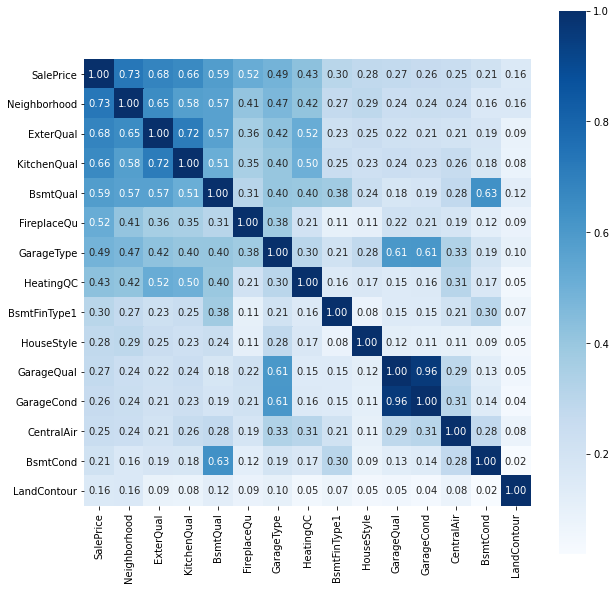

In [17]:
#see correlation matrix with categorical data converted to numerical features

corr_matrix(cat_columns,'SalePrice', 15)

### Takeaways 

- We see that Neighborhood and ExterQual are the two most important features in predicting sale price followed by KitchenQual, BsmtQual and FireplaceQual. 

- Also, Central Air and BsmtCond are not strongly correlated to SalePrice so it seems that we were wrong about that. 

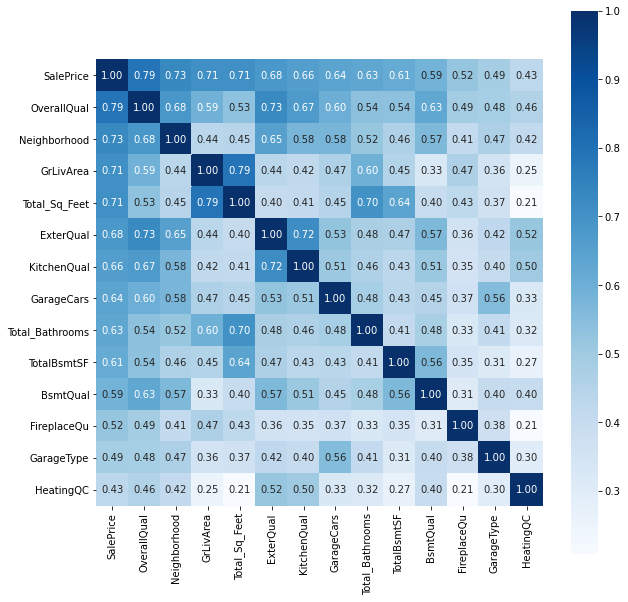

In [18]:
#select columns in cat_columns and num_columns that are correlated well with sale price 

cat_imp = ['Neighborhood','ExterQual','KitchenQual','BsmtQual','FireplaceQu','GarageType','HeatingQC']
cat_columns = cat_columns[cat_imp]

num_imp = ['SalePrice','OverallQual','GrLivArea','Total_Sq_Feet','GarageCars','Total_Bathrooms','TotalBsmtSF']
num_columns = num_columns[num_imp]


#let's merge the two dataframes back together and visualize a correlation matrix 

trained_ready = pd.concat([num_columns, cat_columns], axis=1)

corr_matrix(trained_ready,'SalePrice', 15)

In [19]:
#drop features with a correlation greater than .75 to reduce colinearity 

trained_ready = trained_ready.drop(['GrLivArea'], axis=1)

In [20]:
#detecting outliers and deciding what to do with them

def quantile_info(qu_dataset, qu_field):
  
    iqr = qu_dataset[qu_field].quantile(0.75) - qu_dataset[qu_field].quantile(0.25)
    print("Inter-Quartile Range:", iqr)
    
    upper_boundary = qu_dataset[qu_field].quantile(0.75) + (iqr * 1.5)
    lower_boundary = qu_dataset[qu_field].quantile(0.25) - (iqr * 1.5)
    print("Upper Boundary:", upper_boundary)
    print("Lower Boundary:", lower_boundary)
    
    upper_boundary_extreme = qu_dataset[qu_field].quantile(0.75) + (iqr * 3)
    lower_boundary_extreme = qu_dataset[qu_field].quantile(0.25) - (iqr * 3)
    print("Upper Extreme Boundary:", upper_boundary_extreme)
    print("Lower Extreme Boundary:", lower_boundary_extreme)

    count_over_upper = len(qu_dataset[qu_dataset[qu_field] > upper_boundary])
    count_under_lower = len(qu_dataset[qu_dataset[qu_field] < lower_boundary])
    percentage = 100 * (count_under_lower + count_over_upper) / len(qu_dataset[qu_field])
    print("Percentage of records out of Upper and Lower Boundaries: %.2f"% (percentage))
    
    count_over_upper = len(qu_dataset[qu_dataset[qu_field]>upper_boundary_extreme])
    count_under_lower = len(qu_dataset[qu_dataset[qu_field]<lower_boundary_extreme])
    percentage = 100 * (count_under_lower + count_over_upper) / len(qu_dataset[qu_field])
    print("Percentage of records out of Upper and Lower Extreme Boundaries: %.2f"% (percentage))

for col in trained_ready:
  print("Outlier Detection for ", col, ":")
  quantile_info(trained_ready, col);
  print("---"*10)

Outlier Detection for  SalePrice :
Inter-Quartile Range: 84025.0
Upper Boundary: 340037.5
Lower Boundary: 3937.5
Upper Extreme Boundary: 466075.0
Lower Extreme Boundary: -122100.0
Percentage of records out of Upper and Lower Boundaries: 4.18
Percentage of records out of Upper and Lower Extreme Boundaries: 0.82
------------------------------
Outlier Detection for  OverallQual :
Inter-Quartile Range: 2.0
Upper Boundary: 10.0
Lower Boundary: 2.0
Upper Extreme Boundary: 13.0
Lower Extreme Boundary: -1.0
Percentage of records out of Upper and Lower Boundaries: 0.14
Percentage of records out of Upper and Lower Extreme Boundaries: 0.00
------------------------------
Outlier Detection for  Total_Sq_Feet :
Inter-Quartile Range: 890.5
Upper Boundary: 3719.25
Lower Boundary: 157.25
Upper Extreme Boundary: 5055.0
Lower Extreme Boundary: -1178.5
Percentage of records out of Upper and Lower Boundaries: 2.19
Percentage of records out of Upper and Lower Extreme Boundaries: 0.27
-----------------------

### Takeaways 

There are very few records outside of the extreme bounds so we will keep them since we do not want to lose valuable information. They are also not due to an error so we cannot simply just drop it. Furthermore, we will also be performing transformations on the data so it will help pull in those high numbers.

In [21]:
#let's transform the skewed data that we saw from earlier.

#view skewness numbers, takes in a dataframe and a T/F to evaluate extreme skewness.

def skew_report(df,bool):
    skewValue = pd.DataFrame(df.skew(axis=0))
    new_df = skewValue.rename(columns = {'index': 'Column Name', 0: 'Skewness'}, inplace = False)
    print(new_df.sort_values(by = 'Skewness', ascending = bool).head(20))
    
skew_report(trained_ready,False)

                 Skewness
Total_Sq_Feet    2.163968
SalePrice        1.882876
TotalBsmtSF      1.524255
ExterQual        0.825988
Neighborhood     0.800266
KitchenQual      0.386765
Total_Bathrooms  0.264676
OverallQual      0.216944
FireplaceQu      0.112770
GarageCars      -0.342549
HeatingQC       -0.540458
GarageType      -0.593974
BsmtQual        -1.287571


In [22]:
#transform features greater than 1 and less than -1 using log transformations

#log Transformations

for df in [trained_ready]:
  df['SalePrice_Log'] = np.log(df['SalePrice'])
  df.drop('SalePrice', inplace= True, axis = 1)
    
  df['TotalBsmtSF_Log'] = np.log(df['TotalBsmtSF'])
  df.drop('TotalBsmtSF', inplace= True, axis = 1)
    
  df['Total_SF_Log'] = np.log(df['Total_Sq_Feet'])
  df.drop('Total_Sq_Feet', inplace= True, axis = 1)
    
  df['BsmtQual_Log'] = np.log(df['BsmtQual'])
  df.drop('BsmtQual', inplace= True, axis = 1)

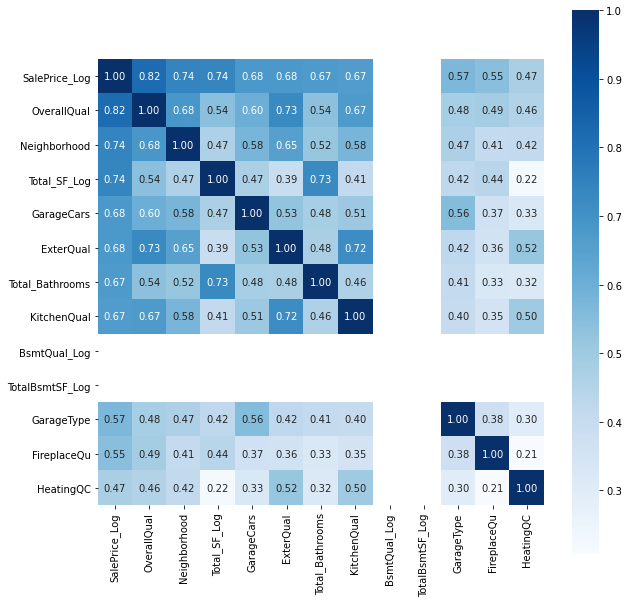

In [23]:
#view correlation matrix with transformed data 

corr_matrix(trained_ready,'SalePrice_Log',15)

### Takeaways 

We can see that some of the features are now more correlated with SalePrice_Log than SalePrice. 

However, it seems that BsmtQual_Log and TotalBsmtSF_Log had some issues in the transformations so let's check it out and see what happened.

In [24]:
trained_ready.BsmtQual_Log.unique()

array([1.38629436, 1.09861229, 1.60943791,       -inf, 0.69314718])

In [25]:
trained_ready.TotalBsmtSF_Log.unique()

array([6.75227038, 7.14045304, 6.82437367, 6.62804138, 7.04315992,
       6.67959919, 7.43011414, 7.00940893, 6.85856503, 6.89871453,
       6.94697599, 7.06902343, 6.81563999, 7.30921237, 7.13329595,
       6.72383244, 6.9117473 ,       -inf, 7.01571242, 6.93634274,
       7.05444966, 6.45676966, 7.48268183, 6.96602419, 7.35627988,
       6.80239476, 7.44073371, 7.30249642, 6.25382881, 6.47543272,
       7.11314211, 7.1180162 , 7.24279792, 7.35308192, 7.0184018 ,
       7.00033446, 7.16780918, 6.96318999, 6.99209643, 7.20785987,
       6.73340189, 6.84374995, 7.04751722, 7.46851327, 7.26822302,
       7.41216033, 6.60123012, 6.86171134, 6.67708346, 6.70441435,
       7.51860722, 5.95064255, 7.26192709, 6.87729607, 6.75693239,
       7.25134498, 6.65929392, 6.27287701, 7.22256602, 6.35610766,
       7.04141166, 7.57404501, 7.28138566, 6.61606519, 7.17319174,
       7.70661291, 6.73933663, 6.9902565 , 6.13556489, 6.51025834,
       7.47760424, 6.08677473, 6.79794041, 7.12044437, 7.35436

#### The Issue 

When we performed log transformations on these two columns, we encoded some of these the categorical features with 0 and the log of 0 is undefined which explains the output of -inf.

Solve this issue by:

- Performing a different transformation on these two features to reduce skewness.
- Adding a constant value.

We will be adding a constant value.

In [26]:
#perform the inverse of the log transformations to get the original values back

for df in [trained_ready]:
  df['SalePrice'] = np.exp(df['SalePrice_Log'])
  df.drop('SalePrice_Log', inplace= True, axis = 1)
    
  df['TotalBsmtSF'] = np.exp(df['TotalBsmtSF_Log'])
  df.drop('TotalBsmtSF_Log', inplace= True, axis = 1)
    
  df['Total_Sq_Feet'] = np.exp(df['Total_SF_Log'])
  df.drop('Total_SF_Log', inplace= True, axis = 1)
    
  df['BsmtQual'] = np.exp(df['BsmtQual_Log'])
  df.drop('BsmtQual_Log', inplace= True, axis = 1)
    

In [27]:
#log Transformations with an added constant value of 1

for df in [trained_ready]:
  df['SalePrice_Log'] = np.log(df['SalePrice']+1)
  df.drop('SalePrice', inplace= True, axis = 1)
    
  df['TotalBsmtSF_Log'] = np.log(df['TotalBsmtSF']+1)
  df.drop('TotalBsmtSF', inplace= True, axis = 1)
    
  df['Total_SF_Log'] = np.log(df['Total_Sq_Feet']+1)
  df.drop('Total_Sq_Feet', inplace= True, axis = 1)
    
  df['BsmtQual_Log'] = np.log(df['BsmtQual']+1)
  df.drop('BsmtQual', inplace= True, axis = 1)

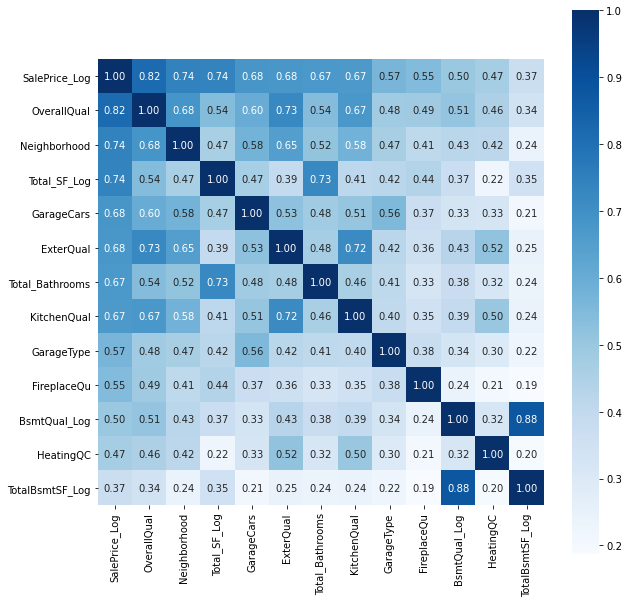

In [28]:
#let's look at the updated correlation matrix 

corr_matrix(trained_ready,'SalePrice_Log',15)

In [29]:
#drop TotalBsmtSF_Log due to colinearity 

trained_ready = trained_ready.drop(['TotalBsmtSF_Log'], axis=1)

In [30]:
#let's look at the updated skewness of the features 

skew_report(trained_ready,False)

                 Skewness
ExterQual        0.825988
Neighborhood     0.800266
KitchenQual      0.386765
Total_Bathrooms  0.264676
OverallQual      0.216944
SalePrice_Log    0.121347
FireplaceQu      0.112770
Total_SF_Log    -0.057541
GarageCars      -0.342549
HeatingQC       -0.540458
GarageType      -0.593974
BsmtQual_Log    -3.613783


#### Issue

BsmtQual_Log is still highly skewed after transformation, let's try a different transformation.

In [31]:
#get back original values

trained_ready['BsmtQual'] = np.exp(trained_ready['BsmtQual_Log'])
trained_ready.drop('BsmtQual_Log', inplace= True, axis = 1)

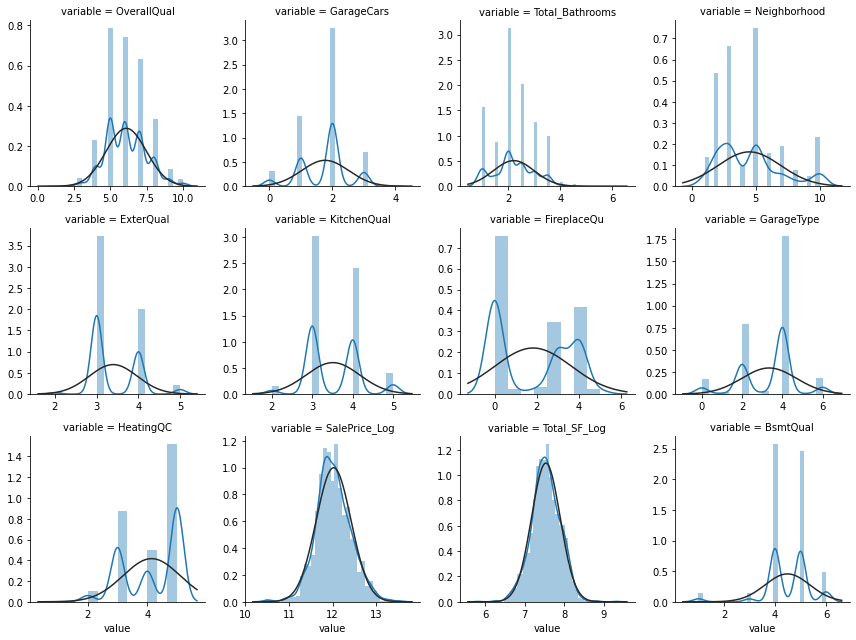

In [32]:
#let's view the skewness of BsmtQual

skew_graph(trained_ready)

In [33]:
#we could perform a squared transformation since the graph is left skewed.

trained_ready['BsmtQual_Sq'] = trained_ready['BsmtQual'] ** 2
trained_ready.drop('BsmtQual', inplace= True, axis = 1)

In [34]:
#let's look at a skewed report

skew_report(trained_ready, False)

                 Skewness
ExterQual        0.825988
Neighborhood     0.800266
KitchenQual      0.386765
Total_Bathrooms  0.264676
OverallQual      0.216944
SalePrice_Log    0.121347
FireplaceQu      0.112770
BsmtQual_Sq      0.054235
Total_SF_Log    -0.057541
GarageCars      -0.342549
HeatingQC       -0.540458
GarageType      -0.593974


#### Exporting for Model Building 

We finally finished all the preprocessing and we are ready to feed the data to machine learning models to make sale price predictions. It would be a good idea to have the cleaned data exported to a new csv file and load that data in.

In [35]:
#exporting to csv

trained_ready.to_csv(r'/Users/matthew_macwan/Downloads/CIS /KAGGLE - house-prices-advanced-regression-techniques/prepared1.csv', index = False, header=True)

### Model Building

In [36]:
#load the data

train_data = pd.read_csv('prepared.csv')

In [37]:
#import some packages

import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import cross_val_score 

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor 

In [38]:
#split the data into a training set and a test set

#separate the other attributes from the predicting attribute

x = trained_ready.drop('SalePrice_Log',axis=1)

#separate the predicting attribute into Y for model training 

y = trained_ready['SalePrice_Log']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 10)

##### Metrics 

- R2 : R Square tells us how much of the variance is explained by the features in the dataset.

- MSE : Mean Squared Error, a popular metric which minimizes the mean of the squared differences between the predicted values and actual values in the dataset.

- RMSE : Root Mean Squared Error, is metric that is an extension of MSE and it makes it easy to see information loss as it is in the same unit as the target variable. E.g. RMSE reports sales price where MSE reports squared sales price.

- MAE : Mean Absolute Error, metric that is used because it is effective with outliers since it is minimized by the median so it will fit closer to the median. However, it does introduce some bias because we are disregarding a few outliers in our dataset.

#### Linear Regression

In [39]:
LR = LinearRegression()

#fitting the training data

LR.fit(x_train,y_train)

#performing predictions 

lr_prediction =  LR.predict(x_test)

In [40]:
#score report

score=r2_score(y_test,lr_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,lr_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,lr_prediction)))
print('MAE:',mean_absolute_error( y_test, lr_prediction ))

R2:  0.8770708377525174
MSE:  0.02165279939976171
RMSE:  0.1471489021357676
MAE: 0.109954082469969


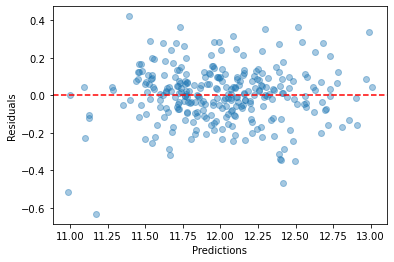

In [126]:
#let's look at the residual plot 

import matplotlib.pyplot as plt

residuals = y_test - lr_prediction

plt.scatter(lr_prediction,residuals,alpha =0.4)
plt.axhline(linewidth=1.5, color='r',linestyle='dashed')
plt.ylabel("Residuals")
plt.xlabel("Predictions")
plt.show()

##### Analysis 

- Residual plot does not show any clear patterns and we can also see that predictions are made on both sides of y=0 meaning that predicted values generally aren't too low or too high.
- The analysis tells us that the linear regression model generalizes pretty well but let's see if we can generalize it some more through Ridge and Lasso regression

#### Ridge Regression

In [98]:
#let's perform grid search to see what are the best hyperparameters

parameters = [{'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 
                'alpha': [0,0.01,0.1,1,5,10]}]

Ridge_pam = GridSearchCV(Ridge(), parameters, scoring='neg_mean_squared_error')
Ridge_pam.fit(x_train, y_train)

print(Ridge_pam.best_params_)

{'alpha': 1, 'solver': 'svd'}


In [102]:
RR = Ridge(alpha=0, solver ="svd")

RR.fit(x_train,y_train)

RR_prediction = RR.predict(x_test)

In [103]:
#performance report

score=r2_score(y_test,RR_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,RR_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,RR_prediction)))
print('MAE:',mean_absolute_error( y_test, RR_prediction ))

R2:  0.8770708377525174
MSE:  0.021652799399761724
RMSE:  0.14714890213576765
MAE: 0.1099540824699691


##### Analysis 

- Grid search tells us that the best hyperparameters for minimizing MSE is an alpha of 1 and chose singular value decomposition (SVD) as the solver.
- When alpha is set to 0, ridge regression is just a linear regression model. An interesting observation is that grid search recommended an alpha of 1 when an alpha of 0 would make more sense since a linear regression model gives a lower MSE when you compare the metrics when alpha =0 and alpha =1. 


#### Lasso Regression

In [90]:
#grid search

parameters = [{'alpha': [0,0.01,0.1,1,5,10]}]

Las_pam = GridSearchCV(Lasso(), parameters, scoring='neg_mean_squared_error')
Las_pam.fit(x_train, y_train)

print(Las_pam.best_params_)

{'alpha': 0}


In [91]:
LasR = Lasso(alpha=0.0)

LasR.fit(x_train,y_train)

LasR_prediction = LasR.predict(x_test)

In [92]:
#performance report

score=r2_score(y_test,LasR_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,LasR_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,LasR_prediction)))
print('MAE:',mean_absolute_error( y_test, LasR_prediction ))

R2:  0.8770708377525173
MSE:  0.021652799399761734
RMSE:  0.14714890213576767
MAE: 0.10995408246996932


#### Elastic Net

In [47]:
#grid search

parameters = [{'l1_ratio':[0,0.01,0.1,0.05,0.1,0.15,0.3,0.5,0.7,0.85], 
                'alpha': [0,0.01,0.1,1,5,10]}]

EN_pam = GridSearchCV(ElasticNet(), parameters, scoring='neg_mean_squared_error')
EN_pam.fit(x_train, y_train)

print(EN_pam.best_params_)

{'alpha': 0, 'l1_ratio': 0}


In [48]:
EN = ElasticNet(alpha=0.01,l1_ratio=0.01)

EN.fit(x_train,y_train)

EN_prediction = EN.predict(x_test)

In [49]:
#performance report

score=r2_score(y_test,EN_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,EN_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,EN_prediction)))
print('MAE:',mean_absolute_error(y_test, EN_prediction))

R2:  0.8756555574851541
MSE:  0.021902087519548648
RMSE:  0.14799353877635554
MAE: 0.11033491016453757


##### Analysis 

- Both Lasso and Elastic Net grid search confirm that the linear regression model is the best model out of 4 so far because the alpha values are 0, which indicates it is a linear regression model.
- Elastic Net is a mix of both lasso and ridge regression where we can control the mix ratio(l_ratio). Grid search returns a zero for both of those values which indicates that the best model to reduce MSE is linear regression.

#### Decision Tree

In [50]:
DTR = DecisionTreeRegressor()

DTR.fit(x_train, y_train)

DTR_prediction = DTR.predict(x_test)

In [51]:
#performance report 

score=r2_score(y_test,DTR_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,DTR_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,DTR_prediction)))
print('MAE:',mean_absolute_error( y_test, DTR_prediction ))

R2:  0.7609241642409511
MSE:  0.04211092810182292
RMSE:  0.2052094737136249
MAE: 0.15266617846307304


##### Analysis 

- The decision tree regressor does not perform nearly as well as the linear regression model. 
- MSE was doubled and the variance explained by the input variables has dropped by approximately 13%.

Let's use an ensemble method such as random forest to see if we can make this model better. Random forest introduces randomness and implements bagging to create many decision trees which are uncorrelated.

#### Random Forest

In [105]:
#grid search

param_grid = [{'n_estimators':[3,10,30,90,200,300,500],'max_features':[2,3,4,5,7,10,12]},
             {'bootstrap':[False],'n_estimators':[3,10,30,90,200,300,500],'max_features':[2,3,4,5,7,10,12]}]

RF = RandomForestRegressor()

grid_RF = GridSearchCV(RF, param_grid, cv = 5, scoring='neg_mean_squared_error')
grid_RF.fit(x_train, y_train)

print(grid_RF.best_params_)

{'max_features': 3, 'n_estimators': 300}


In [108]:
RF = RandomForestRegressor(max_features = 3, n_estimators =300)

RF.fit(x_train,y_train)

RF_prediction = RF.predict(x_test)

In [109]:
#performance report

score=r2_score(y_test,RF_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,RF_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,RF_prediction)))
print('MAE:',mean_absolute_error(y_test, RF_prediction))

R2:  0.8731652299257193
MSE:  0.022340734965754963
RMSE:  0.14946817375533483
MAE: 0.11014558622539648


##### Analysis 

- After performing grid search and inputting the best hyperparameters, the random forest algorithm returns results that are much better than the decision tree.
- MSE and the other metrics are nearly identical to the linear regression model we made earlier. 



In [118]:
#let's perform cross validation

model = [LR, RR, EN, LasR, DTR, RF]

for i in model:
    score = cross_val_score(i, x_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
    print(i,":", -score.mean())

LinearRegression() : 0.0222926968506778
Ridge(alpha=0, solver='svd') : 0.02229269685067779
ElasticNet(alpha=0.01, l1_ratio=0.01) : 0.022437330064055645
Lasso(alpha=0.0) : 0.022292696850677824
DecisionTreeRegressor() : 0.03941605054684223
RandomForestRegressor(max_features=3, n_estimators=300) : 0.021352098283955363


##### Analysis 

- Cross validation is very useful when data is limited and considering we only have about 1500 rows, it is worth performing to prevent overfitting and evaluating our models.

- The choice of k: The common choices for k are usually 10 or 5 but the idea behind a larger or smaller k is that a lower k has less variance and more bias and the opposite is true for a higher k. A higher k is also more computationally expensive.

- After cross validation is performed, we see that random forest algorithm gives us the lowest MSE. 



In many cases, it is an ensemble method that delivers the better results because the model can learn from different errors made by different algorithms or in this particular case, different and uncorrelated decision trees.

#### Ensemble Methods

In [112]:
#let's perform another ensemble method, voting regressor

models = [('LR', LR), ('RR', RR),('LasR', LasR), ('EN', EN),('DTR', DTR), ('RF', RF)]

ensemble = VotingRegressor(models)
ensemble.fit(x_train,y_train)

ensemble_prediction = ensemble.predict(x_test)

In [113]:
#performance report

score=r2_score(y_test,ensemble_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,ensemble_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,ensemble_prediction)))
print('MAE:',mean_absolute_error(y_test, ensemble_prediction))

R2:  0.8800808868881673
MSE:  0.021122607955143882
RMSE:  0.1453361894200611
MAE: 0.10903554523167296


In [127]:
#let's perform cross validation 

score = cross_val_score(ensemble, x_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
print("Ensemble Method MSE:", -score.mean())

Ensemble Method MSE: 0.020911769807863325


##### Analysis 

- This voting regressor works by fitting the initial 6 regressors and then averages the individual predictioms made by each model to form a final prediction.
- The results were better than the models on their own. The voting regressor delivers a lower MSE than the random forest and the cross validated MSE also is lower than every other model. 
- The cross-validation score also ensures that we are not overfitting the ensemble. 

We can see that building an ensemble delivers better results that an individual model. Sometimes, this is not always the case. Ensembles may perform better than an individual model but it is not always a gaurantee. 

Let's add in a bagging regressor and a support vector machine to see if it improves the voting regressor.







In [128]:
#Bagging Regressor 

from sklearn.ensemble import BaggingRegressor 


bag = BaggingRegressor(DecisionTreeRegressor(), n_estimators = 200, bootstrap = True)
bag.fit(x_train,y_train)

bag_prediction = bag.predict(x_test)

score=r2_score(y_test,bag_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,bag_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,bag_prediction)))
print('MAE:',mean_absolute_error(y_test, bag_prediction))

R2:  0.8608892505952391
MSE:  0.02450303163335429
RMSE:  0.15653444232294147
MAE: 0.11661708299255227


In [130]:
#Support Vector Machine 

from sklearn.svm import SVR

#grid search 

parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
                'C': [1,2,3,300,500],
                'max_iter': [1000,100000]}]

SVM = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error')
SVM.fit(x_train, y_train)

print(SVM.best_params_)

{'C': 300, 'kernel': 'rbf', 'max_iter': 100000}


In [131]:
SVM_best = SVR(kernel = 'rbf', C=300, max_iter=10000, epsilon =0.1)
SVM_best.fit(x_train,y_train)

SVM_prediction = SVM_best.predict(x_test)

score=r2_score(y_test,SVM_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,SVM_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,SVM_prediction)))
print('MAE:',mean_absolute_error(y_test, SVM_prediction))

R2:  0.8605797595264151
MSE:  0.02455754553312181
RMSE:  0.1567084730737997
MAE: 0.11757281336891375


In [132]:
#let's create a new voting regressor with bagging and SVR added in

model_2 = [('LR', LR), ('RR', RR),('LasR', LasR), ('EN', EN),('DTR', DTR), ('RF', RF),('SVM',SVM_best),('Bag',bag)]

ensemble = VotingRegressor(model_2)
ensemble.fit(x_train,y_train)

ensemble_prediction = ensemble.predict(x_test)

#performance report

score=r2_score(y_test,ensemble_prediction)
print('R2: ',score)
print('MSE: ',mean_squared_error(y_test,ensemble_prediction))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,ensemble_prediction)))
print('MAE:',mean_absolute_error(y_test, ensemble_prediction))

R2:  0.8800301167184554
MSE:  0.02113155063627962
RMSE:  0.14536695166467384
MAE: 0.10924137504391541


In [133]:
#cross validation

score = cross_val_score(ensemble, x_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
print("Ensemble Method MSE:", -score.mean())

Ensemble Method MSE: 0.020242779548652435


##### Analysis 

- Adding in the support vector machine and the bagging regressor improved the cross validation MSE slightly. From 2.09% to 2.02%. 
- The test MSE was still slightly lower in the model without bagging and SVM. 2.112% compared to 2.113%. I don't know why this is yet but I will continue to research it.


#### Considerations Moving Forward 

This project involved a decent amount of data cleaning, feature engineering and selection, and model building. Here are some of the things I learned and will implement in my next project.

- Splitting the data into a train/validation/test split

- Keeping more of the weaker features to build stronger ensembles and a nueral network. 
